## Environment Setup

**Upload following files to current directory**

1.   *requirements.txt*
2.   *dataloader.py*
3.   *capsule_network.py*
4.   *ccm_pruner.py*
5.   *utils.py*
6.   *model_train_test.py*

In [3]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}"'.format(name=fn))

Saving capsule_network.py to capsule_network.py
Saving ccm_pruner.py to ccm_pruner.py
Saving dataloader.py to dataloader.py
Saving model_train_test.py to model_train_test.py
Saving requirements.txt to requirements.txt
Saving utils.py to utils.py
User uploaded file "capsule_network.py"
User uploaded file "ccm_pruner.py"
User uploaded file "dataloader.py"
User uploaded file "model_train_test.py"
User uploaded file "requirements.txt"
User uploaded file "utils.py"


In [4]:
pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.9 MB/s eta 0:00:00


Importing required libraries

In [5]:
import shutil
import time, datetime
from thop import profile
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn.functional as F

import capsule_network as caps
import ccm_pruner as ccmp
import model_train_test as mtt
import utils
from dataloader import image_dataloader

CapsuleNet is using device: cuda


Device (CPU/GPU) available to use.

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('This notebook using device:', device)

torch.manual_seed(1)

This notebook using device: cuda


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Plots

In [29]:
def plot_line_chart(arrs, legends, xlabel, ylabel, title):
    fig, ax = plt.subplots(figsize=(10, 6))
    epochs = np.arange(1, len(arrs[0])+1)

    for i in range(len(arrs)):
        ax.plot(epochs, arrs[i], 'o-', label = legends[i])

    ax.set_xticks(epochs)
    ax.set_xlabel(xlabel, fontsize = 14)
    ax.set_ylabel(ylabel, fontsize = 14)
    ax.set_title(title, fontsize = 16)
    ax.legend()
    plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
    fig.tight_layout()

## Model Training

In [8]:
ROOT="/content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/"

TRAIN_DIR = ROOT+"train/"
LOG_DIR = ROOT+"logs/"
CIFAR10_TRAIN_DIR = TRAIN_DIR+"cifar10/"

logger = utils.get_logger(LOG_DIR)

In [ ]:
# base_capsnet_mnist = BaseCapsuleNetwork(1, 28, 28, n_class=10)
# base_capsnet_mnist = base_capsnet_mnist.to(device)
# optimizer = Adam(base_capsnet_mnist.parameters())

# train_loader, test_loader = image_dataloader(dataset='mnist')
# criterion = CapsNetLoss()
# n_epochs = 10

In [ ]:
# def test_capsnet(model, criterion, test_loader):
#     losses = utils.AverageMeter('Loss', ':.4e')
#     top1 = utils.AverageMeter('Acc@1', ':6.2f')
#     top5 = utils.AverageMeter('Acc@5', ':6.2f')

#     model.eval()

#     with torch.no_grad():
#         for images, labels in test_loader:
#             batch_size = labels.size(0)

#             images = images.to(device)
#             labels = labels.to(device)

#             reconstructed_images, preds, feature_maps = model(images)
#             data_loss = criterion(preds, labels, images, reconstructed_images)

#             losses.update(data_loss.item(), batch_size)

#             preds = caps.get_v_norm(preds)
#             prec1, prec5 = utils.accuracy(preds, labels, topk=(1, 5))
#             top1.update(prec1.item(), batch_size)
#             top5.update(prec5.item(), batch_size)

#         logger.info('{} Validation - Loss={loss.avg:.4f}, Top 1 Acc={top1.avg:.3f}, Top 5 Acc={top5.avg:.3f}'
#             .format(model.name, loss=losses, top1=top1, top5=top5))

#     return losses.avg, top1.avg, top5.avg

In [ ]:
# def train_capsnet(n_epochs, model, criterion, optimizer,
#                   train_loader, test_loader, train_dir, calc_ccm=False):
#     best_top1 = 0
#     best_trained_model_path = ''
#     epoch_losses = np.zeros((2, n_epochs))
#     epoch_accuracies = np.zeros((2, n_epochs))

#     for epoch in range(1, n_epochs+1):
#         batch_time = utils.AverageMeter('Time', ':6.3f')
#         data_time = utils.AverageMeter('Data', ':6.3f')
#         losses = utils.AverageMeter('Loss', ':.4e')
#         top1 = utils.AverageMeter('Acc@1', ':6.2f')
#         top5 = utils.AverageMeter('Acc@5', ':6.2f')

#         if calc_ccm:
#             CCM_losses = utils.AverageMeter('CCM_loss', ':.4e')

#         model.train()
#         end = time.time()

#         for i, (images, labels) in enumerate(train_loader):
#             batch_size = labels.size(0)
#             num_iter = len(train_loader)

#             images = images.to(device)
#             labels = labels.to(device)

#             data_time.update(time.time() - end)

#             optimizer.zero_grad()

#             reconstructed_images, preds, feature_maps = model(images)
#             loss = criterion(preds, labels, images, reconstructed_images)

#             if calc_ccm:
#                 CCM_loss, _ = ccmp.calc_ccm_loss(feature_maps)
#                 loss = loss - (CCM_loss * 0.09)
#                 CCM_losses.update(CCM_loss.item(), batch_size)

#             loss.backward()
#             optimizer.step()

#             losses.update(loss.item(), batch_size)

#             preds = caps.get_v_norm(preds)
#             prec1, prec5 = utils.accuracy(preds, labels, topk=(1, 5))
#             top1.update(prec1.item(), batch_size)
#             top5.update(prec5.item(), batch_size)

#             batch_time.update(time.time() - end)
#             end = time.time()

#             if i % batch_size == 0:
#                 logger.info('{} Training - Epoch={}, Iteration=({}/{}), Loss={loss.avg:.4f}, Top 1 Acc={top1.avg:.2f}, Top 5 Acc={top5.avg:.2f}'
#                 .format(model.name, epoch, i, num_iter, loss=losses, top1=top1, top5=top5))

#         val_loss, val_top1, val_top5 = test_capsnet(model, criterion, test_loader)

#         # Save model checkpoint
#         if calc_ccm:
#             checkpoint_filename = "Trained_{0}_CCM_Epoch{1}_of_{2}.pt".format(model.name, epoch, n_epochs)
#         else:
#             checkpoint_filename = "Trained_{0}_Epoch{1}_of_{2}.pt".format(model.name, epoch, n_epochs)
#         utils.save_checkpoint(train_dir, checkpoint_filename, model.state_dict(),
#                               optimizer.state_dict(), (losses.avg, val_loss),
#                               (top1.avg, val_top1), (top5, val_top5))
#         logger.info("Saved Checkpoint: {}".format(train_dir+checkpoint_filename))

#         # Identify best accuracy to save best model
#         if val_top1 > best_top1:
#             best_top1 = val_top1
#             best_trained_model_path = train_dir+checkpoint_filename

#         epoch_losses[:, epoch-1] = (losses.avg, val_loss)
#         epoch_accuracies[:, epoch-1] = (top1.avg, val_top1)

#     logger.info("{} best accuracy={:.3f} saved at: {}".format(model.name, best_top1, best_trained_model_path))

#     # Saving best trained model
#     if not calc_ccm:
#         utils.save_best_model(train_dir, model.name, best_trained_model_path)

#     return best_trained_model_path, epoch_losses, epoch_accuracies

In [ ]:
n_class=10
n_epochs=30
batch_size=64

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

100%|██████████| 170498071/170498071 [00:01<00:00, 88680867.41it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# criterion = caps.CapsNetLoss(n_class)

# base_capsnet_cifar10 = caps.BaseCapsuleNetwork(3, 32, 32, n_class=n_class)
# base_capsnet_cifar10 = base_capsnet_cifar10.to(device)

# base_capsnet_cifar10.name = "BaseCapsuleNetwork"

# print("Base Capsule Network Model: ", base_capsnet_cifar10)

Base Capsule Network Model:  BaseCapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv_layer): Conv2d(3, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2), padding=valid)
    )
  )
  (class_caps): ClassCapsLayer()
  (routing_aggreement): RoutingByAggreement()
  (caps_decoder): CapsDecoder(
    (fully_conn_layers): Sequential(
      (0): Linear(in_features=160, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=3072, bias=True)
      (5): Sigmoid()
    )
  )
)


In [ ]:
1/0 # To Stop executing the next cell

ZeroDivisionError: ignored

In [ ]:
# best_trained_model_path, losses, accuracies = mtt.train_capsnet(n_epochs,
#                                                                 base_capsnet_cifar10,
#                                                                 criterion,
#                                                                 train_loader,
#                                                                 test_loader,
#                                                                 CIFAR10_TRAIN_DIR,
#                                                                 logger,
#                                                                 device=device)

12/23 01:06:39 AM | BaseCapsuleNetwork Training - Epoch=1, Iteration=(0/782), Loss=0.8094, Top 1 Acc=15.62, Top 5 Acc=56.25
INFO:capsnet:BaseCapsuleNetwork Training - Epoch=1, Iteration=(0/782), Loss=0.8094, Top 1 Acc=15.62, Top 5 Acc=56.25
12/23 01:06:52 AM | BaseCapsuleNetwork Training - Epoch=1, Iteration=(64/782), Loss=0.5025, Top 1 Acc=28.94, Top 5 Acc=77.19
INFO:capsnet:BaseCapsuleNetwork Training - Epoch=1, Iteration=(64/782), Loss=0.5025, Top 1 Acc=28.94, Top 5 Acc=77.19
12/23 01:07:06 AM | BaseCapsuleNetwork Training - Epoch=1, Iteration=(128/782), Loss=0.4582, Top 1 Acc=33.67, Top 5 Acc=82.30
INFO:capsnet:BaseCapsuleNetwork Training - Epoch=1, Iteration=(128/782), Loss=0.4582, Top 1 Acc=33.67, Top 5 Acc=82.30
12/23 01:07:20 AM | BaseCapsuleNetwork Training - Epoch=1, Iteration=(192/782), Loss=0.4381, Top 1 Acc=36.21, Top 5 Acc=84.56
INFO:capsnet:BaseCapsuleNetwork Training - Epoch=1, Iteration=(192/782), Loss=0.4381, Top 1 Acc=36.21, Top 5 Acc=84.56
12/23 01:07:34 AM | BaseCa

In [ ]:
# torch.save({"epoch_loss":losses,
#             "epoch_acc":accuracies},
#             CIFAR10_TRAIN_DIR+'Trained_BaseCapsuleNetwork_Epoch_Loss_Accuracy.pt')

# print(best_trained_model_path)

/content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/train/cifar10/Trained_BaseCapsuleNetwork_Epoch13_of_30.pt


In [ ]:
base_capsnet_cifar10_flops, base_capsnet_cifar10_params = profile(base_capsnet_cifar10,
                                                                  inputs=(torch.randn(batch_size, 3, 32, 32, device=device),))

print("Base CapsNet CIFAR10 Flops = {}".format(base_capsnet_cifar10_flops))
print("Base CapsNet CIFAR10 Params = {}".format( base_capsnet_cifar10_params))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
Base CapsNet CIFAR10 Flops = 417254604800.0
Base CapsNet CIFAR10 Params = 9127680.0


In [ ]:
data = torch.load(CIFAR10_TRAIN_DIR+'Trained_BaseCapsuleNetwork_Epoch_Loss_Accuracy.pt')
data

{'epoch_loss': array([[0.37298621, 0.29948814, 0.26544929, 0.2426811 , 0.22473447,
         0.20890146, 0.19277656, 0.17694223, 0.16236511, 0.14845921,
         0.13337383, 0.11927475, 0.10346971, 0.09096132, 0.07840562,
         0.06658444, 0.05649606, 0.04872624, 0.04061614, 0.03382704,
         0.02951705, 0.02548917, 0.0224899 , 0.02098897, 0.01795827,
         0.0161612 , 0.01474972, 0.01408236, 0.01256169, 0.01238112],
        [0.31915806, 0.28600312, 0.26653649, 0.25063165, 0.25048621,
         0.2419806 , 0.23086774, 0.23319739, 0.22735079, 0.2291827 ,
         0.22976894, 0.2274409 , 0.22515172, 0.23079509, 0.2317396 ,
         0.23737442, 0.23787703, 0.24472584, 0.24268179, 0.24711576,
         0.2468001 , 0.25905291, 0.26240893, 0.25612806, 0.26315939,
         0.26726824, 0.266053  , 0.26848848, 0.26505162, 0.26764396]]),
 'epoch_acc': array([[45.982, 58.21 , 63.82 , 67.318, 70.384, 73.094, 75.926, 78.45 ,
         80.956, 83.146, 85.492, 87.718, 90.006, 91.568, 93.416, 94.

In [ ]:
losses = data['epoch_loss']
accuracies = data['epoch_acc']

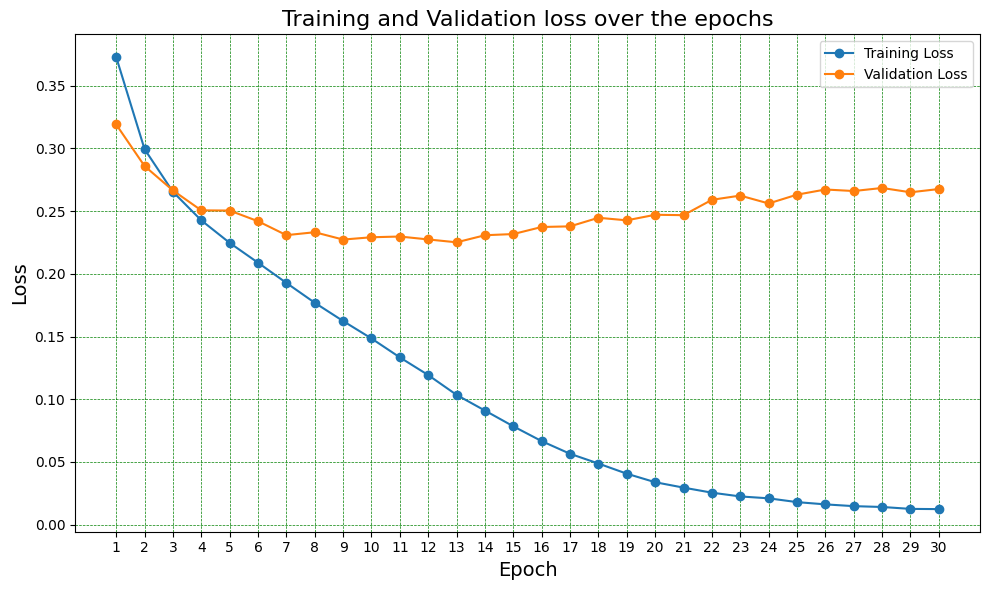

In [ ]:
plot_line_chart(losses, ['Training Loss', 'Validation Loss'],
                'Epoch', 'Loss', 'Training and Validation loss over the epochs')

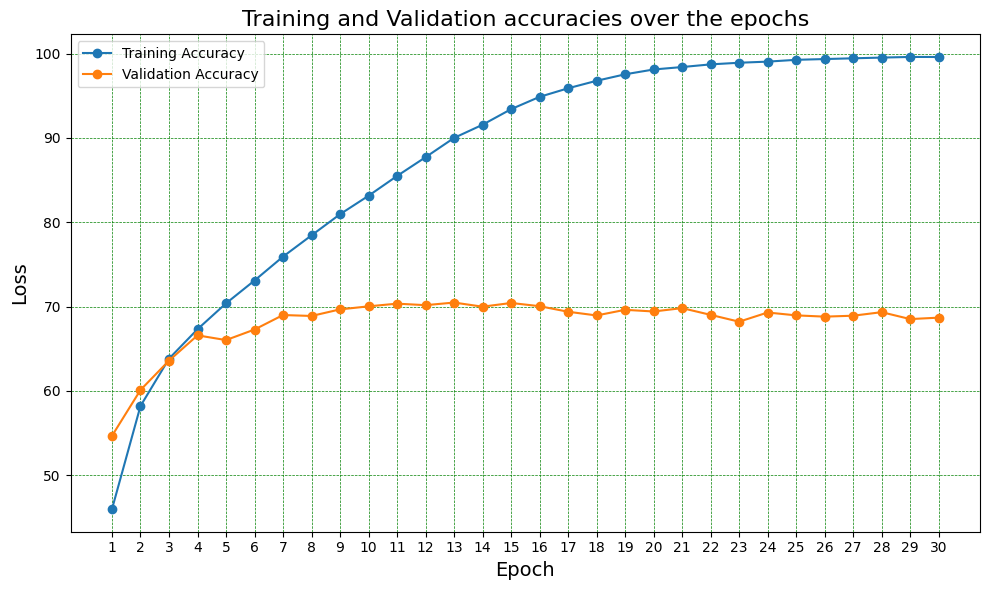

In [ ]:
plot_line_chart(accuracies, ['Training Accuracy', 'Validation Accuracy'],
                'Epoch', 'Loss', 'Training and Validation accuracies over the epochs')

### Training with CCM loss

In [ ]:
n_class=10
n_epochs=50
batch_size=64

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

100%|██████████| 170498071/170498071 [00:04<00:00, 37029360.11it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
criterion = caps.CapsNetLoss(n_class)

base_capsnet_cifar10_model = caps.BaseCapsuleNetwork(3, 32, 32, n_class=10)

best_trained_model = torch.load(CIFAR10_TRAIN_DIR+'Best_BaseCapsuleNetwork.pt', map_location=device)

base_capsnet_cifar10_model.load_state_dict(best_trained_model['model_state_dict'])
base_capsnet_cifar10_model.to(device)

BaseCapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv_layer): Conv2d(3, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2), padding=valid)
    )
  )
  (class_caps): ClassCapsLayer()
  (routing_aggreement): RoutingByAggreement()
  (caps_decoder): CapsDecoder(
    (fully_conn_layers): Sequential(
      (0): Linear(in_features=160, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=3072, bias=True)
      (5): Sigmoid()
    )
  )
)

In [ ]:
# best_trained_ccm_model_path, losses_ccm, accuracies_ccm = mtt.train_capsnet(n_epochs,
#                                                                             base_capsnet_cifar10_model,
#                                                                             criterion,
#                                                                             train_loader,
#                                                                             test_loader,
#                                                                             CIFAR10_TRAIN_DIR,
#                                                                             logger,
#                                                                             calc_ccm=True,
#                                                                             device=device)

12/23 02:42:06 AM | BaseCapsuleNetwork Training - Epoch=1, Iteration=(0/782), Loss=0.0367, Top 1 Acc=95.31, Top 5 Acc=100.00
INFO:capsnet:BaseCapsuleNetwork Training - Epoch=1, Iteration=(0/782), Loss=0.0367, Top 1 Acc=95.31, Top 5 Acc=100.00
12/23 02:42:20 AM | BaseCapsuleNetwork Training - Epoch=1, Iteration=(64/782), Loss=0.0489, Top 1 Acc=91.75, Top 5 Acc=98.97
INFO:capsnet:BaseCapsuleNetwork Training - Epoch=1, Iteration=(64/782), Loss=0.0489, Top 1 Acc=91.75, Top 5 Acc=98.97
12/23 02:42:34 AM | BaseCapsuleNetwork Training - Epoch=1, Iteration=(128/782), Loss=0.0455, Top 1 Acc=92.20, Top 5 Acc=99.21
INFO:capsnet:BaseCapsuleNetwork Training - Epoch=1, Iteration=(128/782), Loss=0.0455, Top 1 Acc=92.20, Top 5 Acc=99.21
12/23 02:42:48 AM | BaseCapsuleNetwork Training - Epoch=1, Iteration=(192/782), Loss=0.0463, Top 1 Acc=92.10, Top 5 Acc=99.27
INFO:capsnet:BaseCapsuleNetwork Training - Epoch=1, Iteration=(192/782), Loss=0.0463, Top 1 Acc=92.10, Top 5 Acc=99.27
12/23 02:43:02 AM | Base

Checkpoint restart

In [ ]:
checkpoint_file='/content/drive/MyDrive/MSc_AI/Course/OCOM5300M-AI_Project/code_repository/results/train/cifar10/Trained_BaseCapsuleNetwork_CCM_Epoch23_of_50.pt'

In [ ]:
best_trained_ccm_model_path, losses_ccm, accuracies_ccm = mtt.train_capsnet(n_epochs,
                                                                            base_capsnet_cifar10_model,
                                                                            criterion,
                                                                            train_loader,
                                                                            test_loader,
                                                                            CIFAR10_TRAIN_DIR,
                                                                            logger,
                                                                            calc_ccm=True,
                                                                            device=device,
                                                                            checkpoint_file=checkpoint_file)

12/23 04:18:57 PM | BaseCapsuleNetwork Training - Epoch=24, Iteration=(0/782), Loss=-0.0363, Top 1 Acc=100.00, Top 5 Acc=100.00
INFO:capsnet:BaseCapsuleNetwork Training - Epoch=24, Iteration=(0/782), Loss=-0.0363, Top 1 Acc=100.00, Top 5 Acc=100.00
12/23 04:19:05 PM | BaseCapsuleNetwork Training - Epoch=24, Iteration=(64/782), Loss=-0.0292, Top 1 Acc=99.71, Top 5 Acc=99.95
INFO:capsnet:BaseCapsuleNetwork Training - Epoch=24, Iteration=(64/782), Loss=-0.0292, Top 1 Acc=99.71, Top 5 Acc=99.95
12/23 04:19:13 PM | BaseCapsuleNetwork Training - Epoch=24, Iteration=(128/782), Loss=-0.0315, Top 1 Acc=99.81, Top 5 Acc=99.96
INFO:capsnet:BaseCapsuleNetwork Training - Epoch=24, Iteration=(128/782), Loss=-0.0315, Top 1 Acc=99.81, Top 5 Acc=99.96
12/23 04:19:21 PM | BaseCapsuleNetwork Training - Epoch=24, Iteration=(192/782), Loss=-0.0319, Top 1 Acc=99.82, Top 5 Acc=99.98
INFO:capsnet:BaseCapsuleNetwork Training - Epoch=24, Iteration=(192/782), Loss=-0.0319, Top 1 Acc=99.82, Top 5 Acc=99.98
12/23 

## CCM and CI scores calculation

Loading CCM Model for feature maps channel importance score

In [18]:
batch_size=64

train_loader, test_loader = image_dataloader(dataset='cifar10', batch_size=batch_size)

base_capsnet_cifar10_ccm_model = caps.BaseCapsuleNetwork(3, 32, 32, n_class=10)

best_trained_model = torch.load(CIFAR10_TRAIN_DIR+'Trained_BaseCapsuleNetwork_CCM_Epoch50_of_50.pt', map_location=device)

base_capsnet_cifar10_ccm_model.load_state_dict(best_trained_model['model_state_dict'])
base_capsnet_cifar10_ccm_model = base_capsnet_cifar10_ccm_model.to(device)
base_capsnet_cifar10_ccm_model.eval()

Files already downloaded and verified
Files already downloaded and verified


BaseCapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv_layer): Conv2d(3, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2), padding=valid)
    )
  )
  (class_caps): ClassCapsLayer()
  (routing_aggreement): RoutingByAggreement()
  (caps_decoder): CapsDecoder(
    (fully_conn_layers): Sequential(
      (0): Linear(in_features=160, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=3072, bias=True)
      (5): Sigmoid()
    )
  )
)

Extract Correlation Coefficient Matrix

In [31]:
%%time
base_capsnet_cifar10_ccm_model.eval()

n_layers = 2
layer_ccm_list = [ [] for _ in range(n_layers) ]
layer_mean_ccm_list = []

with torch.no_grad():
    for images, _ in train_loader:
        images = images.to(device)

        _, _, batch_layer_feature_maps = base_capsnet_cifar10_ccm_model(images)

        for indx, batch_feature_maps in enumerate(batch_layer_feature_maps):
            _, batch_ccm = ccmp.calc_ccm_loss(batch_feature_maps)
            layer_ccm_list[indx].append(batch_ccm.detach().cpu())

        torch.cuda.empty_cache()

for i in range(n_layers):
    layer_mean_ccm_list.append(torch.mean(torch.stack(layer_ccm_list[i]), dim=0))

ccmp.save_ccm(layer_mean_ccm_list, CIFAR10_TRAIN_DIR, 'base_capsnet_cifar10_ccm')

base_capsnet_cifar10_ccm saved
CPU times: user 50.1 s, sys: 27.4 s, total: 1min 17s
Wall time: 1min 16s


Channel Importance Scores

In [18]:
%%time
base_capsnet_cifar10_ccm_model.eval()

layer_ci_list = []

with torch.no_grad():
    for images, _ in train_loader:
        batch_layer_ci_scores = []
        images = images.to(device)

        batch_conv_layer_feature_maps = base_capsnet_cifar10_ccm_model.conv_layer(images)
        _, batch_pcaps_layer_feature_maps = base_capsnet_cifar10_ccm_model.primary_caps(batch_conv_layer_feature_maps)

        batch_conv_layer_ci_scores = ccmp.ci_score(batch_conv_layer_feature_maps)
        batch_pcaps_layer_ci_scores = ccmp.ci_score(batch_pcaps_layer_feature_maps)

        batch_layer_ci_scores.append(batch_conv_layer_ci_scores.detach().cpu().numpy())
        batch_layer_ci_scores.append(batch_pcaps_layer_ci_scores.detach().cpu().numpy())

        layer_ci_list.append(batch_layer_ci_scores)
        torch.cuda.empty_cache()

    layer_ci_mean = np.mean(layer_ci_list, axis=0)

    np.save(CIFAR10_TRAIN_DIR+'base_capsnet_cifar10_ci_scores.npy', layer_ci_mean)

CPU times: user 22min 56s, sys: 4.72 s, total: 23min
Wall time: 22min 55s


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:164: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asanyarray(a)


## Pruning CapsNet

In [9]:
base_capsnet_layer_ccm = ccmp.load_ccm(CIFAR10_TRAIN_DIR, 'base_capsnet_cifar10_ccm')
base_capsnet_layer_ci_scores = np.load(CIFAR10_TRAIN_DIR+'base_capsnet_cifar10_ci_scores.npy', allow_pickle=True)

layers = [  'conv_layer',
            'primary_caps'  ]
threshold = 0.25
channels_to_preserve = {}

for indx, layer in enumerate(layers):
    channels_to_preserve[layer] =  ccmp.get_channels_to_preserve(base_capsnet_layer_ci_scores[indx],
                                                                 base_capsnet_layer_ccm[indx],
                                                                 threshold=threshold)

In [10]:
def prune_layer_model(model, input_channels, n_class, layers_to_prune, channels_to_preserve):
    import copy

    model_state_dict = model.state_dict()
    new_model = copy.deepcopy(model)

    new_conv_layer_n_channels = 0
    new_pcaps_layer_n_channels = 0

    for indx, layer in enumerate(layers_to_prune):
        if layer.startswith('conv_layer'):
            layer_weight_name = layer+'.weight'
            layer_bias_name = layer+'.bias'
            preserve_channels = channels_to_preserve['conv_layer']

            new_layer_weight = torch.index_select(model_state_dict[layer_weight_name], 0, torch.tensor(preserve_channels, device=device))
            new_layer_bias = torch.index_select(model_state_dict[layer_bias_name], 0, torch.tensor(preserve_channels, device=device))

            new_conv_layer_n_channels = len(preserve_channels)
            new_model.conv_layer = caps.ConvLayer(input_channels, new_conv_layer_n_channels)

            new_model.state_dict()[layer_weight_name] = new_layer_weight
            new_model.state_dict()[layer_bias_name] = new_layer_bias

        elif layer.startswith('primary_caps'):
            layer_weight_name = layer+'.weight'
            layer_bias_name = layer+'.bias'
            preserve_channels = channels_to_preserve['primary_caps']

            new_layer_weight = torch.index_select(model_state_dict[layer_weight_name], 0, torch.tensor(preserve_channels, device=device))
            new_layer_bias = torch.index_select(model_state_dict[layer_bias_name], 0, torch.tensor(preserve_channels, device=device))

            new_pcaps_layer_n_channels = len(preserve_channels)
            new_model.primary_caps = caps.PrimaryCapsLayer(new_conv_layer_n_channels, new_pcaps_layer_n_channels)

            new_model.state_dict()[layer_weight_name] = new_layer_weight
            new_model.state_dict()[layer_bias_name] = new_layer_bias

    prev_n_prim_caps = model_state_dict['class_caps.weights'].shape[0]
    prev_prim_caps_out_channels = model_state_dict['primary_caps.primary_caps.0.weight'].shape[0]

    new_n_prim_caps = int((prev_n_prim_caps / prev_prim_caps_out_channels) * new_pcaps_layer_n_channels)

    new_model.class_caps = caps.ClassCapsLayer(n_class=n_class, n_prim_caps=new_n_prim_caps)
    new_model.routing_aggreement = caps.RoutingByAggreement(n_in_caps=new_n_prim_caps, n_out_caps=n_class)

    return new_model

### 25% Pruning Base CapsNet

In [11]:
layers_to_prune = ['conv_layer.conv_layer',
                   'primary_caps.primary_caps.0',
                   'primary_caps.primary_caps.1',
                   'primary_caps.primary_caps.2',
                   'primary_caps.primary_caps.3',
                   'primary_caps.primary_caps.4',
                   'primary_caps.primary_caps.5',
                   'primary_caps.primary_caps.6',
                   'primary_caps.primary_caps.7']

In [69]:
pruned_base_capsnet_ccm_model = prune_layer_model(base_capsnet_cifar10_ccm_model, 3, 10, layers_to_prune, channels_to_preserve)
pruned_base_capsnet_ccm_model.name = 'pruned_base_capsnet_ccm_model'
pruned_base_capsnet_ccm_model.to(device)

BaseCapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv_layer): Conv2d(3, 192, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): ModuleList(
      (0-7): 8 x Conv2d(192, 24, kernel_size=(9, 9), stride=(2, 2), padding=valid)
    )
  )
  (class_caps): ClassCapsLayer()
  (routing_aggreement): RoutingByAggreement()
  (caps_decoder): CapsDecoder(
    (fully_conn_layers): Sequential(
      (0): Linear(in_features=160, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=3072, bias=True)
      (5): Sigmoid()
    )
  )
)

In [70]:
pruned_base_capsnet_cifar10_flops, pruned_base_capsnet_cifar10_params = profile(pruned_base_capsnet_ccm_model,
                                                                                inputs=(torch.randn(batch_size, 3, 32, 32, device=device),))

print("Base CapsNet CIFAR10 Flops = {}".format(pruned_base_capsnet_cifar10_flops))
print("Base CapsNet CIFAR10 Params = {}".format(pruned_base_capsnet_cifar10_params))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
Base CapsNet CIFAR10 Flops = 14190641152.0
Base CapsNet CIFAR10 Params = 6789568.0


#### Pruned Model Fine Tunning

In [71]:
# n_class = 10
# n_epochs = 50

# criterion = caps.CapsNetLoss(n_class)

# pruned_best_trained_ccm_model_path, losses_ccm, accuracies_ccm = mtt.train_capsnet(n_epochs,
#                                                                                    pruned_base_capsnet_ccm_model,
#                                                                                    criterion,
#                                                                                    train_loader,
#                                                                                    test_loader,
#                                                                                    CIFAR10_TRAIN_DIR,
#                                                                                    logger,
#                                                                                    device=device)

12/26 01:50:17 AM | pruned_base_capsnet_ccm_model Training - Epoch=1, Iteration=(0/782), Loss=0.8086, Top 1 Acc=14.06, Top 5 Acc=56.25
INFO:capsnet:pruned_base_capsnet_ccm_model Training - Epoch=1, Iteration=(0/782), Loss=0.8086, Top 1 Acc=14.06, Top 5 Acc=56.25
12/26 01:50:27 AM | pruned_base_capsnet_ccm_model Training - Epoch=1, Iteration=(64/782), Loss=0.5066, Top 1 Acc=27.14, Top 5 Acc=74.71
INFO:capsnet:pruned_base_capsnet_ccm_model Training - Epoch=1, Iteration=(64/782), Loss=0.5066, Top 1 Acc=27.14, Top 5 Acc=74.71
12/26 01:50:37 AM | pruned_base_capsnet_ccm_model Training - Epoch=1, Iteration=(128/782), Loss=0.4625, Top 1 Acc=32.24, Top 5 Acc=80.60
INFO:capsnet:pruned_base_capsnet_ccm_model Training - Epoch=1, Iteration=(128/782), Loss=0.4625, Top 1 Acc=32.24, Top 5 Acc=80.60
12/26 01:50:47 AM | pruned_base_capsnet_ccm_model Training - Epoch=1, Iteration=(192/782), Loss=0.4426, Top 1 Acc=34.93, Top 5 Acc=83.33
INFO:capsnet:pruned_base_capsnet_ccm_model Training - Epoch=1, Itera

#### Plots for losses and accuracies

In [23]:
pruned_25pc_base_capsnet_cifar10_model_path = CIFAR10_TRAIN_DIR+'Trained_pruned_25pc_base_capsnet_ccm_model_Epoch50_of_50.pt'
pruned_25pc_base_capsnet_cifar10_model = torch.load(pruned_25pc_base_capsnet_cifar10_model_path)

epoch_loss = pruned_25pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = pruned_25pc_base_capsnet_cifar10_model['epoch_accuracy']

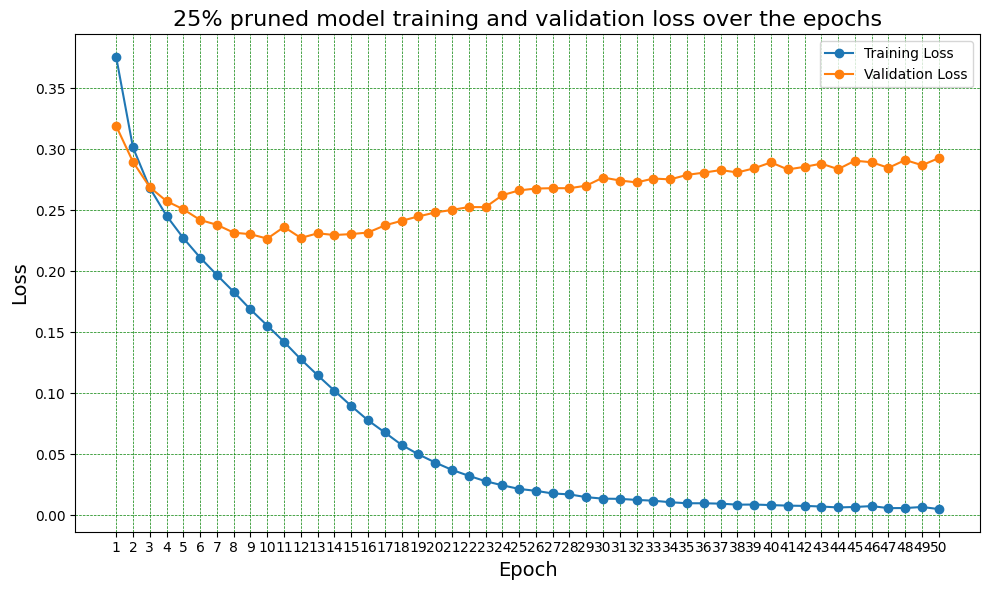

In [31]:
plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'],
                'Epoch', 'Loss', '25% pruned model training and validation loss over the epochs')

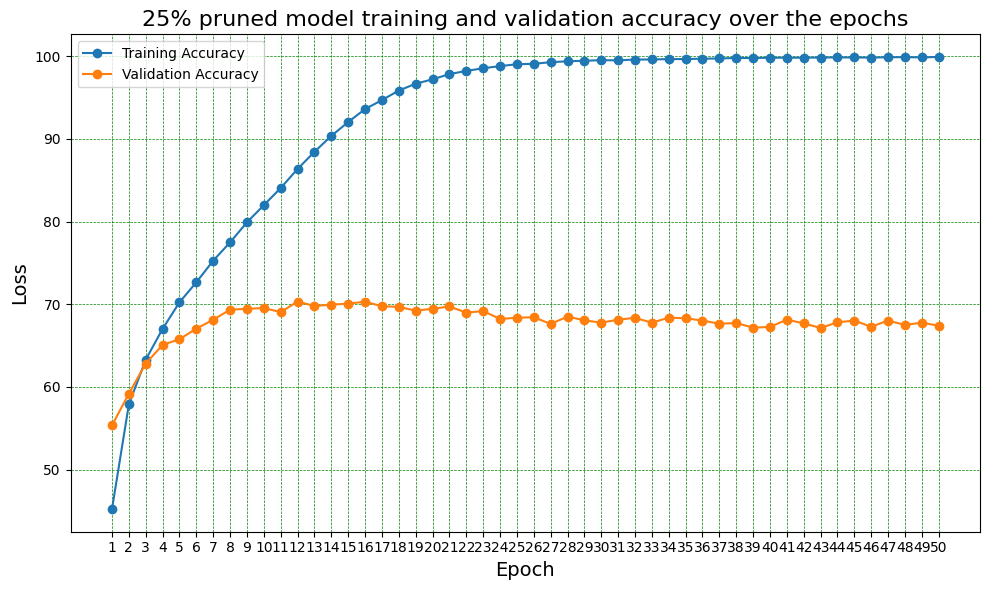

In [32]:
plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'],
                'Epoch', 'Loss', '25% pruned model training and validation accuracy over the epochs')

### 50% Pruning Base CapsNet

In [33]:
base_capsnet_layer_ccm = ccmp.load_ccm(CIFAR10_TRAIN_DIR, 'base_capsnet_cifar10_ccm')
base_capsnet_layer_ci_scores = np.load(CIFAR10_TRAIN_DIR+'base_capsnet_cifar10_ci_scores.npy', allow_pickle=True)

layers = [  'conv_layer',
            'primary_caps'  ]
threshold = 0.50
channels_to_preserve = {}

for indx, layer in enumerate(layers):
    channels_to_preserve[layer] =  ccmp.get_channels_to_preserve(base_capsnet_layer_ci_scores[indx],
                                                                 base_capsnet_layer_ccm[indx],
                                                                 threshold=threshold)

In [34]:
pruned_50pc_base_capsnet_ccm_model = prune_layer_model(base_capsnet_cifar10_ccm_model, 3, 10, layers_to_prune, channels_to_preserve)
pruned_50pc_base_capsnet_ccm_model.name = 'pruned_50pc_base_capsnet_ccm_model'
pruned_50pc_base_capsnet_ccm_model.to(device)

BaseCapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv_layer): Conv2d(3, 128, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_caps): PrimaryCapsLayer(
    (primary_caps): ModuleList(
      (0-7): 8 x Conv2d(128, 16, kernel_size=(9, 9), stride=(2, 2), padding=valid)
    )
  )
  (class_caps): ClassCapsLayer()
  (routing_aggreement): RoutingByAggreement()
  (caps_decoder): CapsDecoder(
    (fully_conn_layers): Sequential(
      (0): Linear(in_features=160, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=3072, bias=True)
      (5): Sigmoid()
    )
  )
)

In [36]:
pruned_base_capsnet_cifar10_flops, pruned_base_capsnet_cifar10_params = profile(pruned_50pc_base_capsnet_ccm_model,
                                                                                inputs=(torch.randn(batch_size, 3, 32, 32, device=device),))

print("Base CapsNet CIFAR10 pruned 50% Flops = {}".format(pruned_base_capsnet_cifar10_flops))
print("Base CapsNet CIFAR10 pruned 50% Params = {}".format(pruned_base_capsnet_cifar10_params))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
Base CapsNet CIFAR10 pruned 50% Flops = 6822559744.0
Base CapsNet CIFAR10 pruned 50% Params = 5115008.0


#### Pruned Model Fine Tuning

In [35]:
n_epochs = 30

pruned_25pc_base_capsnet_cifar10_model_path, losses_ccm, accuracies_ccm = mtt.train_capsnet(n_epochs,
                                                                                   pruned_50pc_base_capsnet_ccm_model,
                                                                                   criterion,
                                                                                   train_loader,
                                                                                   test_loader,
                                                                                   CIFAR10_TRAIN_DIR,
                                                                                   logger,
                                                                                   device=device)

12/26 06:48:18 PM | pruned_50pc_base_capsnet_ccm_model Training - Epoch=1, Iteration=(0/782), Loss=0.8071, Top 1 Acc=10.94, Top 5 Acc=39.06
INFO:capsnet:pruned_50pc_base_capsnet_ccm_model Training - Epoch=1, Iteration=(0/782), Loss=0.8071, Top 1 Acc=10.94, Top 5 Acc=39.06
12/26 06:48:24 PM | pruned_50pc_base_capsnet_ccm_model Training - Epoch=1, Iteration=(64/782), Loss=0.4955, Top 1 Acc=27.07, Top 5 Acc=76.49
INFO:capsnet:pruned_50pc_base_capsnet_ccm_model Training - Epoch=1, Iteration=(64/782), Loss=0.4955, Top 1 Acc=27.07, Top 5 Acc=76.49
12/26 06:48:31 PM | pruned_50pc_base_capsnet_ccm_model Training - Epoch=1, Iteration=(128/782), Loss=0.4572, Top 1 Acc=32.78, Top 5 Acc=81.52
INFO:capsnet:pruned_50pc_base_capsnet_ccm_model Training - Epoch=1, Iteration=(128/782), Loss=0.4572, Top 1 Acc=32.78, Top 5 Acc=81.52
12/26 06:48:37 PM | pruned_50pc_base_capsnet_ccm_model Training - Epoch=1, Iteration=(192/782), Loss=0.4377, Top 1 Acc=35.40, Top 5 Acc=83.88
INFO:capsnet:pruned_50pc_base_cap

#### Plots for losses and accuracies

In [37]:
pruned_50pc_base_capsnet_cifar10_model_path = CIFAR10_TRAIN_DIR+'Trained_pruned_50pc_base_capsnet_ccm_model_Epoch30_of_30.pt'
pruned_50pc_base_capsnet_cifar10_model = torch.load(pruned_50pc_base_capsnet_cifar10_model_path)

epoch_loss = pruned_50pc_base_capsnet_cifar10_model['epoch_loss']
epoch_accuracy = pruned_50pc_base_capsnet_cifar10_model['epoch_accuracy']

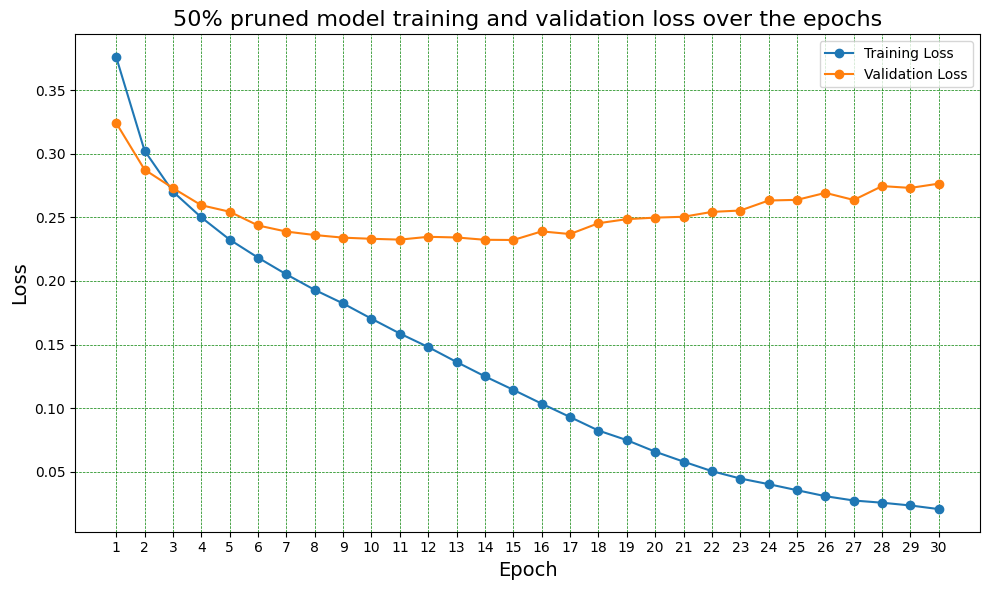

In [38]:
plot_line_chart(epoch_loss, ['Training Loss', 'Validation Loss'],
                'Epoch', 'Loss', '50% pruned model training and validation loss over the epochs')

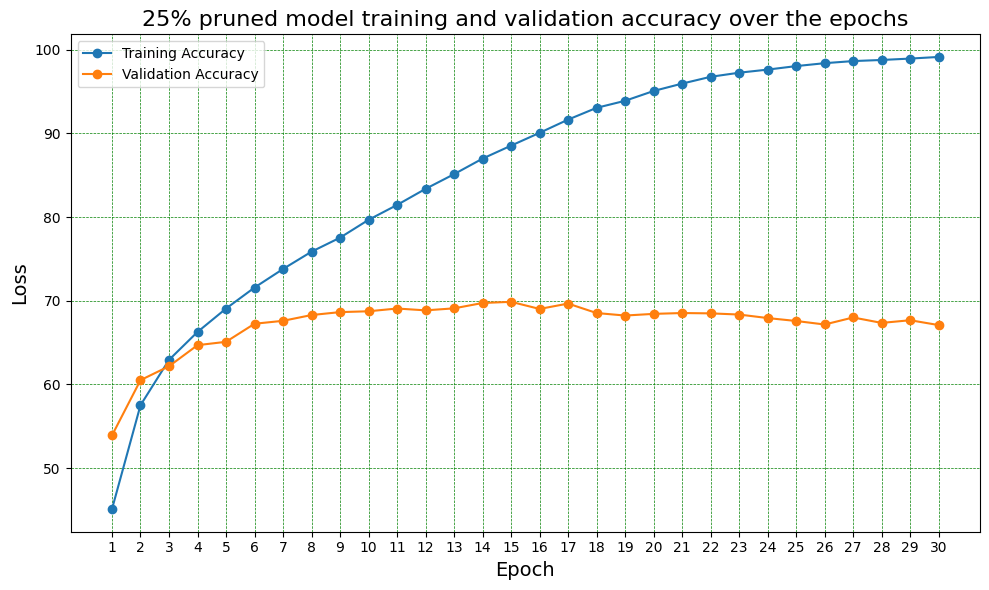

In [39]:
plot_line_chart(epoch_accuracy, ['Training Accuracy', 'Validation Accuracy'],
                'Epoch', 'Loss', '50% pruned model training and validation accuracy over the epochs')

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

def plot_images_separately(images):
    fig = plt.figure()
    for j in range(1, 7):
        ax = fig.add_subplot(1, 6, j)
        image = images[j-1]
        ax.imshow(image.T)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()

In [ ]:
plot_images_separately(images[:6, :].cpu())

In [ ]:
recon_image = reconstructed_images[4]
recon_image = recon_image.cpu().detach().numpy()

plt.imshow(recon_image.T)